In [24]:
import time
import pandas as pd
import torch
import matplotlib.pyplot as plt

from foqal.utils.io import IO
from foqal.causal.classical import ClassicalCommonCause, Superdeterminism, Superluminal
from foqal.causal.quantum import QuantumCommonCause
from foqal.fit import fit

In [36]:
print(f"CUDA is available: {torch.cuda.is_available()}")
device = "cpu"
verbose = True

io = IO.directory(
    folder="simulated-data-causal-two-qubit-depolarizing", include_date=False, include_id=False, verbose=False,
)
m = 20
p = 0.0
latent_dim = 100
lr = 0.10
n_steps = 2000

CUDA is available: True


In [37]:
train_data = torch.Tensor(io.load_np_array(filename=f"m={m}_p={int(100 * p)}_{0}.npy")).to(device)
test_data = torch.Tensor(io.load_np_array(filename=f"m={m}_p={int(100 * p)}_{1}.npy")).to(device)

In [38]:
model = ClassicalCommonCause(n_settings=m, latent_dim=latent_dim)

In [39]:
df = []
curves = {}
for Model in [
    ClassicalCommonCause,
    Superdeterminism,
    Superluminal,
    QuantumCommonCause,
]:
    if Model is QuantumCommonCause:
        _latent_dim = 2
    else:
        _latent_dim = latent_dim

    model = Model(n_settings=m, latent_dim=_latent_dim)
    model = model.to(device)

    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    loss = torch.nn.KLDivLoss()

    t0 = time.time()
    losses = fit(model, train_data, optimizer, loss, n_steps=n_steps, progress=True)
    t1 = time.time()

    if verbose:
        print(
            f"\n{model.__class__.__name__} | "
            f"\n\tTotal time: {t1 - t0}| "
            f"\n\tTotal parameters: {sum(p.numel() for p in model.parameters())}"
            f"\n\tFinal loss: {losses[-1]}"
        )

    torch.cuda.empty_cache()

    loss_test = loss(model.forward(), test_data)
    if loss_test.is_cuda:
        loss_test = loss_test.cpu().detach().numpy().item()
    else:
        loss_test = loss_test.detach().numpy().item()

    df.append(dict(
        model=model.__class__.__name__,
        m=m,
        p=p,
        latent_dim=_latent_dim,
        train_loss=losses[-1].item(),
        test_loss=loss_test,
        t=(t1 - t0),
        lr=lr,
        n_steps=n_steps,
    ))
    curves[model.__class__.__name__] = losses

io.verbose = True

Cost: 0.0047518997: 100%|██████████| 2000/2000 [00:08<00:00, 228.36it/s]



ClassicalCommonCause | 
	Total time: 8.759877920150757| 
	Total parameters: 4100
	Final loss: 0.004751899745315313


Cost: 0.0000691153: 100%|██████████| 2000/2000 [00:11<00:00, 170.35it/s]



Superdeterminism | 
	Total time: 11.74229884147644| 
	Total parameters: 6100
	Final loss: 6.911525269970298e-05


Cost: 0.0000623052: 100%|██████████| 2000/2000 [00:10<00:00, 198.11it/s]



Superluminal | 
	Total time: 10.097547769546509| 
	Total parameters: 42100
	Final loss: 6.230515282368287e-05


Cost: 0.0001746908: 100%|██████████| 2000/2000 [00:22<00:00, 87.29it/s] 


QuantumCommonCause | 
	Total time: 22.91480278968811| 
	Total parameters: 180
	Final loss: 0.00017469078011345118


In [40]:
print(train_data[:, :, 0, 0])

tensor([[4.9801e-01, 4.9652e-04],
        [4.9652e-04, 5.0099e-01]])


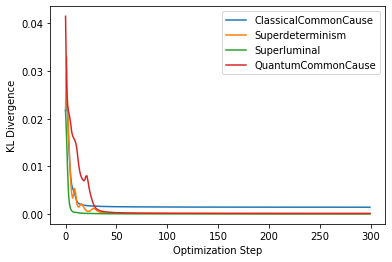

In [12]:
for label, curve in curves.items():
    plt.plot(curve, label=label)
plt.xlabel('Optimization Step')
plt.ylabel('KL Divergence')
plt.legend()
plt.show()

In [13]:
df = pd.DataFrame(df)
print(df)

                  model   m    p  latent_dim  train_loss  test_loss  \
0  ClassicalCommonCause  40  0.0         100    0.001467   0.001484   
1      Superdeterminism  40  0.0         100    0.000112   0.000232   
2          Superluminal  40  0.0         100    0.000062   0.000280   
3    QuantumCommonCause  40  0.0           2    0.000172   0.000178   

           t    lr  n_steps  
0   6.823362  0.25      300  
1  10.501652  0.25      300  
2   9.677078  0.25      300  
3   7.595635  0.25      300  
